參考: https://reurl.cc/DZNNQR
Github: https://github.com/yacoubb/stock-trading-ml

# TBD

1. 整理 code
2. * 討論標準化的方法(min-max scalar, standard scalar)
     * 例如：一開始就正規化所有的資料(含 test)作法是否正確，因為 min-max scalar 隨股價上漲，導致正規化的標準會參考到 test 的資料
     * 目前增加 DCO 和 DHL 兩個 features，討論其影響
3. 測試紀錄不同的股票
4. 改進交易策略

* Introduction
  * LSTM 簡介
* method
  * ipynb 內容講解
* result
  * 準確度(MSE)與賺多少錢(交易策略)
* discussion
  * 列還可以改的參數 blablabla
  
## Todo:


* 台股/美股各選 3 隻，並且搭配不一樣的參數去跑（the technical indicators used, history_points hyperparameter, buy/sell algorithm/hyperparameters and model architecture ），統計出我們最好的 LSTM 的策略
* 加入 sharp ratio 去比較三種評分方式(sharp ratio/MSE/漲跌預測正確率)的優缺及適合的交易策略

In [5]:
# [不管美股/台股都要跑這裡] 設定變數，後面會用到（改 stock_id 即可） 

stock_id = 'MSFT' # e.g. 2330(台股) or MSFT(美股)
start_date, end_date = '2001-12-01', '2021-12-28'
csvname = './data/' + stock_id +'_daily.csv'
h5name = './data/' + stock_id + '_daily.h5'

In [6]:
# 下載美股用此 function
def save_dataset(symbol):
    
    from alpha_vantage.timeseries import TimeSeries
    
    api_key = "TZ1RUCWBNBED2EWJ"

    ts = TimeSeries(key=api_key, output_format='pandas')
    data, _ = ts.get_daily(symbol, outputsize='full')
    
    data = data.reset_index()
    data = data.drop('date', axis=1)
    data = data.drop(0, axis=0)
    
    data.columns = ["Open", "High", "Low", "Close", "Volume"]
    data['DCO'] = data['Close'] - data['Open']
    data['DHL'] = data['High'] - data['Low']
    print(data.tail())

    data.to_csv(csvname, index=False)
    print(len(data.columns))
    return len(data.columns)

# 下載台股用此 function
def save_dataset_TW():


    from FinMind.data import DataLoader

    api = DataLoader()
    df = api.taiwan_stock_daily(
        stock_id=stock_id,
        start_date=start_date,
        end_date=end_date
    )

    df = df.drop(columns=['date', 'stock_id', 'Trading_money', 'spread', 'Trading_turnover']) 
    df = df.rename(columns={"open":"Open",
                            "max":"High",
                            "min":"Low",
                            "close": "Close",
                            "Trading_Volume": "Volume"})
    df = df[["Open", "High", "Low", "Close", "Volume"]]
    df['DCO'] = df['Close'] - df['Open']
    df['DHL'] = df['High'] - df['Low']

    # 設定參數，設定 model 時用
    num_of_features = len(df.columns)
    df.to_csv(csvname, index=False)
    
    return num_of_features

# 

In [7]:
# Preprocess functions

import pandas as pd
from sklearn import preprocessing
import numpy as np

history_points = 50

def csv_to_dataset(csv_path):
    
    data = pd.read_csv(csv_path, index_col=False)

    # 1. X(normalised) - 把 ohlcv + DCO + DHL 資料正規化
    #                    用 {history_points = 50} 去生成 history_points parameter（用此去預測 the next open value）
    data = data.values
    data_normaliser = preprocessing.MinMaxScaler()
    data_normalised = data_normaliser.fit_transform(data)
    ohlcv_histories_normalised = np.array([data_normalised[i:i + history_points].copy() for i in range(len(data_normalised) - history_points)])
    print(data_normalised)

    # 2. y(normalised) - 收集正規化的 next day open values，並且展維(for keras)
    next_day_open_values_normalised = np.array([data_normalised[:, 0][i + history_points].copy() for i in range(len(data_normalised) - history_points)])
    next_day_open_values_normalised = np.expand_dims(next_day_open_values_normalised, -1)

    # 3. unscaled_y + 展維（for keras）
    next_day_open_values = np.array([data[:, 0][i + history_points].copy() for i in range(len(data) - history_points)])
    next_day_open_values = np.expand_dims(next_day_open_values, -1)

    # 4. 
    y_normaliser = preprocessing.MinMaxScaler()
    y_normaliser.fit(next_day_open_values) 

    def calc_ema(values, time_period):
        # https://www.investopedia.com/ask/answers/122314/what-exponential-moving-average-ema-formula-and-how-ema-calculated.asp
        sma = np.mean(values[:, 3])
        ema_values = [sma]
        k = 2 / (1 + time_period)
        for i in range(len(his) - time_period, len(his)):
            close = his[i][3]
            ema_values.append(close * k + ema_values[-1] * (1 - k))
        return ema_values[-1]

    # 額外新增技術指標 [SMA（{history_points = 50}日平均 close price）, ]
    technical_indicators = []
    for his in ohlcv_histories_normalised:
        sma = np.mean(his[:, 3])
        macd = calc_ema(his, 12) - calc_ema(his, 26)
        technical_indicators.append(np.array([sma]))
        # 範例: technical_indicators.append(np.array([sma,macd,]))

    # 正規化
    technical_indicators = np.array(technical_indicators)
    tech_ind_scaler = preprocessing.MinMaxScaler()
    technical_indicators_normalised = tech_ind_scaler.fit_transform(technical_indicators)

    # Output:
    #   ohlcv_histories_normalised: 正規化的 X
    #   technical_indicators_normalised: 正規化的技術指數
    #   next_day_open_values_normalised: 正規化的 y
    #   next_day_open_values: 未正規化的 y
    #   y_normaliser: 未正規化的 y --> (y_normaliser) --> next_day_open_values_normalised
    assert ohlcv_histories_normalised.shape[0] == next_day_open_values_normalised.shape[0] == technical_indicators_normalised.shape[0]
    return ohlcv_histories_normalised, technical_indicators_normalised, next_day_open_values_normalised, next_day_open_values, y_normaliser


In [8]:
# Preprocess 
num_of_features = save_dataset(stock_id)
ohlcv_histories, technical_indicators, next_day_open_values, unscaled_y, y_normaliser  = csv_to_dataset(csvname)

# split train and test
#   ohlcv_train: 0.9; y_train: 0.9
#   ohlcv_test:  0.1; y_test: 0.1
#   unscaled_y_test: 0.1                

test_split = 0.9
n = int(ohlcv_histories.shape[0] * test_split)

ohlcv_train = ohlcv_histories[:n]
tech_ind_train = technical_indicators[:n]
y_train = next_day_open_values[:n]

ohlcv_test = ohlcv_histories[n:]
tech_ind_test = technical_indicators[n:]
y_test = next_day_open_values[n:]

unscaled_y_test = unscaled_y[n:]

print('# of training data: ', n)
print('# of testing data: ', ohlcv_histories.shape[0] - n)

       Open   High    Low  Close      Volume   DCO   DHL
5575  91.81  92.87  90.50  91.56  35083700.0 -0.25  2.37
5576  92.31  92.75  90.31  91.75  27119700.0 -0.56  2.44
5577  92.94  93.50  91.50  92.00  22258500.0 -0.94  2.00
5578  92.75  94.50  91.94  92.56  23174500.0 -0.19  2.56
5579  93.25  94.19  92.12  92.37  26630600.0 -0.88  2.07
7
[[0.98145225 0.96912139 0.98060062 ... 0.02037261 0.41974249 0.16033254]
 [0.99177342 0.98042209 0.98967403 ... 0.01733364 0.40257511 0.19857482]
 [0.98992168 0.98392456 0.99230135 ... 0.01570597 0.5416309  0.21330166]
 ...
 [0.23599053 0.23313875 0.23410625 ... 0.0280377  0.47339056 0.0888361 ]
 [0.23541376 0.23613232 0.23545046 ... 0.02960297 0.5055794  0.11543943]
 [0.23693158 0.23520431 0.23600037 ... 0.0355088  0.47596567 0.09216152]]
# of training data:  4976
# of testing data:  553


![](https://i.imgur.com/XKEjgLw.png)

* The input layer has shape (history_points, OHLCV), since each input data point is an array shaped like [50 × 5]
* The model has 50 LSTM cells in the first layer,
* A dropout layer to prevent overfitting
* Some dense layers to bring all of the LSTM data together.
* An important feature of this network is the linear output activation, allowing the model to tune its penultimate weights accurately

In [9]:
# build training model

import tensorflow as tf
from keras.models import Model
from keras.layers import Dense, Dropout, LSTM, Input, Activation, concatenate
import numpy as np
np.random.seed(4)
tf.random.set_seed(4)

# define two sets of inputs
# {history_points = 50} 的 ohlcv 餵到 lstm_input
lstm_input = Input(shape=(history_points, num_of_features), name='lstm_input') 
# 技術指標餵到 tech_input
dense_input = Input(shape=(technical_indicators.shape[1],), name='tech_input')
 
# the first branch operates on the first input
x = LSTM(50, name='lstm_0')(lstm_input)
x = Dropout(0.2, name='lstm_dropout_0')(x)
lstm_branch = Model(inputs=lstm_input, outputs=x)
 
# the second branch opreates on the second input
y = Dense(20, name='tech_dense_0')(dense_input)
y = Activation("relu", name='tech_relu_0')(y)
y = Dropout(0.2, name='tech_dropout_0')(y)
technical_indicators_branch = Model(inputs=dense_input, outputs=y)
 
# combine the output of the two branches
combined = concatenate([lstm_branch.output, technical_indicators_branch.output], name='concatenate')
 
z = Dense(64, activation="sigmoid", name='dense_pooling')(combined)
z = Dense(1, activation="linear", name='dense_out')(z)
 
# our model will accept the inputs of the two branches and then output a single value
model = Model(inputs=[lstm_branch.input, technical_indicators_branch.input], outputs=z)

adam = tf.optimizers.Adam(learning_rate=0.0005)

model.compile(optimizer=adam, loss='mse')

2022-01-04 21:32:39.412458: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-01-04 21:32:39.412493: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-01-04 21:32:40.543927: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-01-04 21:32:40.543954: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-01-04 21:32:40.543972: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (epl): /proc/driver/nvidia/version does not exist
2022-01-04 21:32:40.544197: I tensorflow/core/platform/cpu_feature_guard.

In [10]:
# training

model.fit(x=[ohlcv_train, tech_ind_train], y=y_train, batch_size=32, epochs=50, shuffle=True, validation_split=0.1)
evaluation = model.evaluate([ohlcv_test, tech_ind_test], y_test)
print(evaluation)

Epoch 1/50
140/140 [==============================] - 5s 27ms/step - loss: 0.0097 - val_loss: 1.1781e-04
Epoch 2/50
140/140 [==============================] - 3s 25ms/step - loss: 5.2321e-04 - val_loss: 8.8554e-05
Epoch 3/50
140/140 [==============================] - 3s 24ms/step - loss: 4.4109e-04 - val_loss: 7.3811e-05
Epoch 4/50
140/140 [==============================] - 3s 24ms/step - loss: 4.0046e-04 - val_loss: 6.6540e-05
Epoch 5/50
140/140 [==============================] - 3s 24ms/step - loss: 3.7588e-04 - val_loss: 6.0443e-05
Epoch 6/50
140/140 [==============================] - 3s 23ms/step - loss: 3.2149e-04 - val_loss: 7.1555e-05
Epoch 7/50
140/140 [==============================] - 3s 24ms/step - loss: 3.2724e-04 - val_loss: 5.9379e-05
Epoch 8/50
140/140 [==============================] - 3s 24ms/step - loss: 3.0042e-04 - val_loss: 5.5488e-05
Epoch 9/50
140/140 [==============================] - 3s 24ms/step - loss: 2.6716e-04 - val_loss: 6.9714e-05
Epoch 10/50
140/140 [==

In [11]:
# evaluation

# 用剛剛 train 好的 model 去預測 test 的資料
y_test_predicted = model.predict([ohlcv_test, tech_ind_test])
# 把正規劃的還原成原本的 next day open price
y_test_predicted = y_normaliser.inverse_transform(y_test_predicted)

assert unscaled_y_test.shape == y_test_predicted.shape

# 算 mse(實際-預測)
real_mse = np.mean(np.square(unscaled_y_test - y_test_predicted))

scaled_mse = real_mse / (np.max(unscaled_y_test) - np.min(unscaled_y_test)) * 100
print(scaled_mse)

60.57350867407985


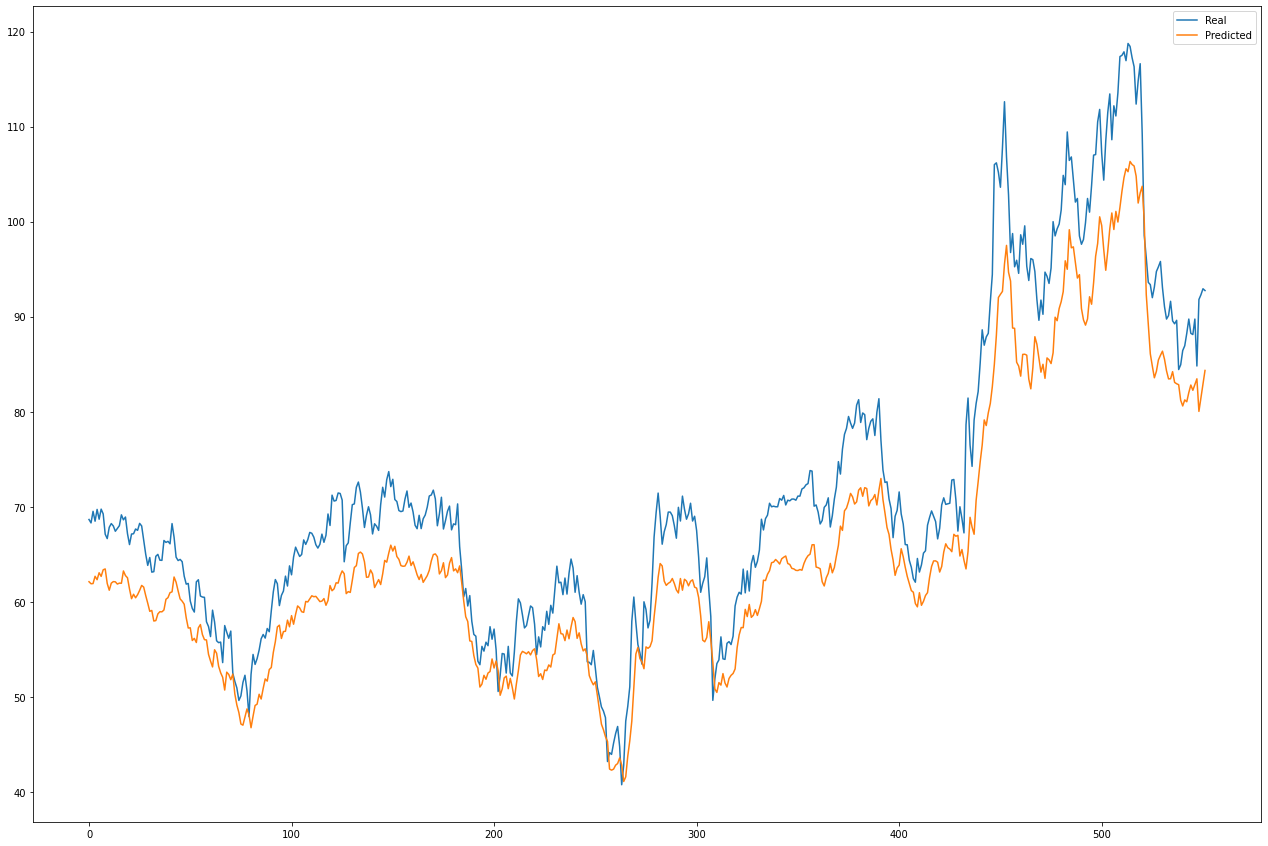

In [12]:
# ploting

import matplotlib.pyplot as plt

plt.gcf().set_size_inches(22, 15, forward=True)

start = 0
end = -1

real = plt.plot(unscaled_y_test[start:end], label='real')
pred = plt.plot(y_test_predicted[start:end], label='predicted')

plt.legend(['Real', 'Predicted'])
plt.show()

model.save(h5name)

# 實際設計 Algo 來看可以靠預測來賺多少 

In [13]:
# 交易策略 1

buys = []
sells = []
thresh = 0.0

start = 0
end = -1

x = -1

# go through 20 年找買所有的買賣點（明日開盤價夠高就買，夠低就賣）
for i, (ohlcv, ind) in enumerate(zip(ohlcv_test[start: end], tech_ind_test[start: end])):
    normalised_price_today = ohlcv[-1][0]
    normalised_price_today = np.array([[normalised_price_today]])
    price_today = y_normaliser.inverse_transform(normalised_price_today)
    predicted_price_tomorrow = np.squeeze(y_normaliser.inverse_transform(model.predict([ohlcv.reshape(1, 50, -1), ind.reshape(1, -1)])))
    if i > 0:
        delta = (predicted_price_tomorrow - predicted_price_today) / predicted_price_today
        # print(predicted_price_tomorrow, predicted_price_today, delta)
        if delta > thresh:
            buys.append((x, price_today[0][0])) #（第幾筆買點, 買價）
        elif delta < -thresh:
            sells.append((x, price_today[0][0])) #（第幾筆賣點, 賣價）
        x += 1
    predicted_price_today = predicted_price_tomorrow

print(f"buys: {len(buys)}")
print(f"sells: {len(sells)}")

buys: 283
sells: 268


In [14]:
# evaluation by the forwardtesting

# 買點買10塊股票 賣點則把手上股票出清
def compute_earnings(buys, sells):
    purchase_amt = 10
    stock = 0
    balance = 0
    while len(buys) > 0 and len(sells) > 0:
        if buys[0][0] < sells[0][0]:
            # time to buy $10 worth of stock
            balance -= purchase_amt
            stock += purchase_amt / buys[0][1]
            buys.pop(0)
        else:
            # time to sell all of our stock
            balance += stock * sells[0][1]
            stock = 0
            sells.pop(0)
    print('$', balance)

# we create new lists not to modify the original data
compute_earnings([b for b in buys], [s for s in sells])




$ 6.882958297003968


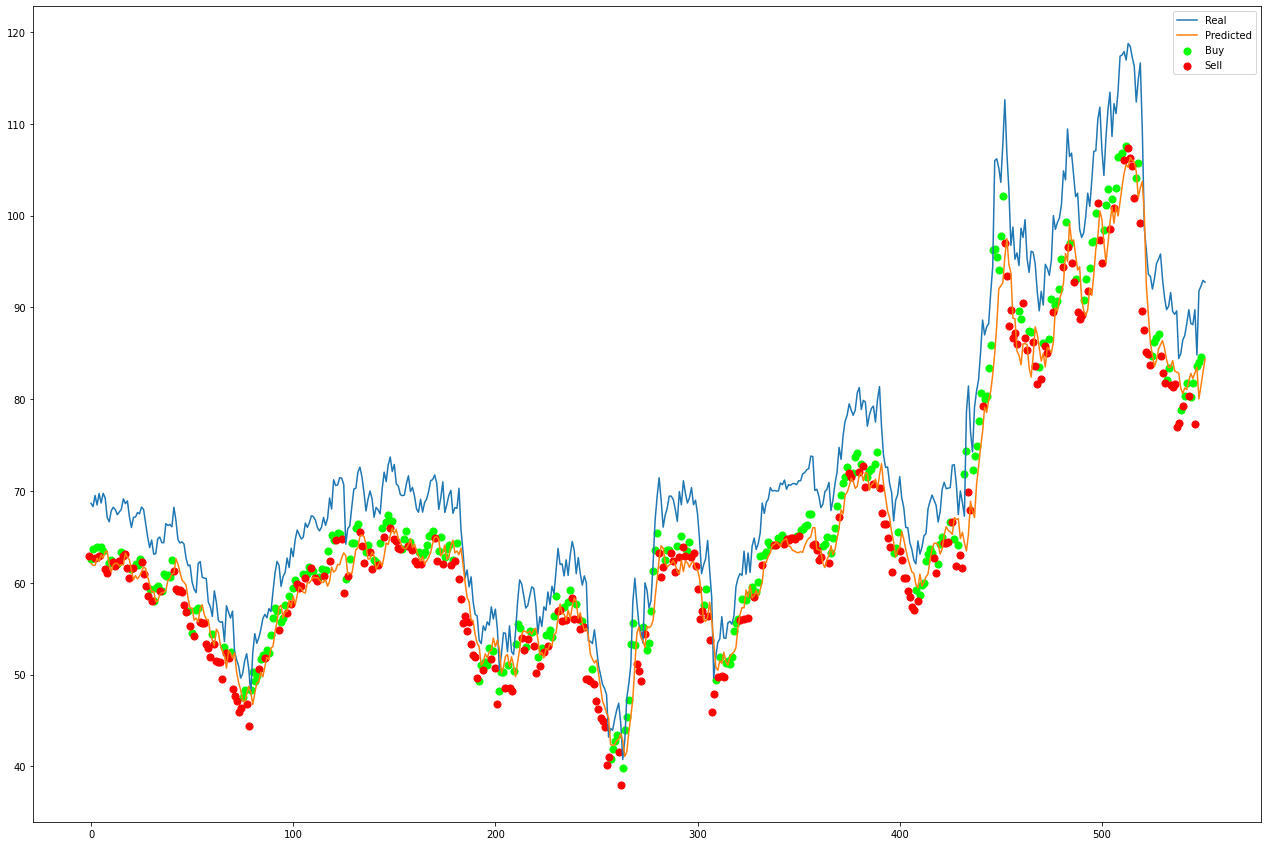

In [15]:
# plot buy points and sell points 

plt.gcf().set_size_inches(22, 15, forward=True)

real = plt.plot(unscaled_y_test[start:end], label='real')
pred = plt.plot(y_test_predicted[start:end], label='predicted')

if len(buys) > 0:
    plt.scatter(list(list(zip(*buys))[0]), list(list(zip(*buys))[1]), c='#00ff00', s=50)
if len(sells) > 0:
    plt.scatter(list(list(zip(*sells))[0]), list(list(zip(*sells))[1]), c='#ff0000', s=50)

plt.legend(['Real', 'Predicted', 'Buy', 'Sell'])

plt.show()